# Air Pollution Forecasting 
### Por: Oliver Burguete López 

Este es un dataset que reporta el clima y el nivel de contaminación cada hora durante cinco años en la embajada de EEUU en Beijing, China.

Los datos incluyen la fecha (por hora), la contaminación denominada concentración de PM2,5 y la información meteorológica.

Estos datos se van a usar para plantear un problema de previsión en el que, dadas las condiciones meteorológicas y la contaminación de las horas anteriores, se pueda hacer una predicción de la contaminación de las siguiente horas.

Este problema es relevante porque permite predecir niveles de contaminación (PM2.5) basados en condiciones meteorológicas previas, lo cual ayuda a proteger la salud pública al alertar a los ciudadanos y autoridades sobre períodos peligrosos. Con estas predicciones, se pueden tomar medidas preventivas como reducir actividades contaminantes, emitir alertas tempranas, y guiar la planificación urbana para mitigar la contaminación, optimizando así la respuesta ante riesgos ambientales y mejorando la calidad de vida en áreas urbanas.

Se usarán las capas de LSTM para que el modelo sea capaz de hacer predicciones basadas en una memoria de las horas pasadas. Se va a probar de igual manera hacer la redes neuronales con un entrenamiento de solo la variable a predecir (contaminación) y comparar la posible mejora cuando se entrena con un las demás variables para que estas den el contexto necesario para mejorar el accuracy de la predicción.

El dataset que se usará es de Kaggle: https://www.kaggle.com/datasets/rupakroy/lstm-datasets-multivariate-univariate/data

In [74]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rupakroy/lstm-datasets-multivariate-univariate")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\User\.cache\kagglehub\datasets\rupakroy\lstm-datasets-multivariate-univariate\versions\4


In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Bidirectional

In [76]:
csv_path = f"{path}/LSTM-Multivariate_pollution.csv"
test_csv_path = f"{path}/pollution_test_data1.csv"

df = pd.read_csv(csv_path)
test_df = pd.read_csv(test_csv_path)

df['date'] = pd.to_datetime(df['date'])

df.head()

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


Los datos con los que se trabaja son de un rango de fechas de 2010-01.01 a 2014-12-31. En el siguiente código se puede ver la distribución de los valores numéricos.

In [89]:
df[['pollution', 'dew', 'temp', 'press', 'wnd_spd']].describe()

,pollution,dew,temp,press,wnd_spd
count,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000
mean,94.013516,1.828516,12.459041,1016.447306,23.894307
std,92.252276,14.429326,12.193384,10.271411,50.022729
min,0.000000,-40.000000,-19.000000,991.000000,0.450000
25%,24.000000,-10.000000,2.000000,1008.000000,1.790000
50%,68.000000,2.000000,14.000000,1016.000000,5.370000
75%,132.250000,15.000000,23.000000,1025.000000,21.910000
max,994.000000,28.000000,42.000000,1046.000000,585.600000


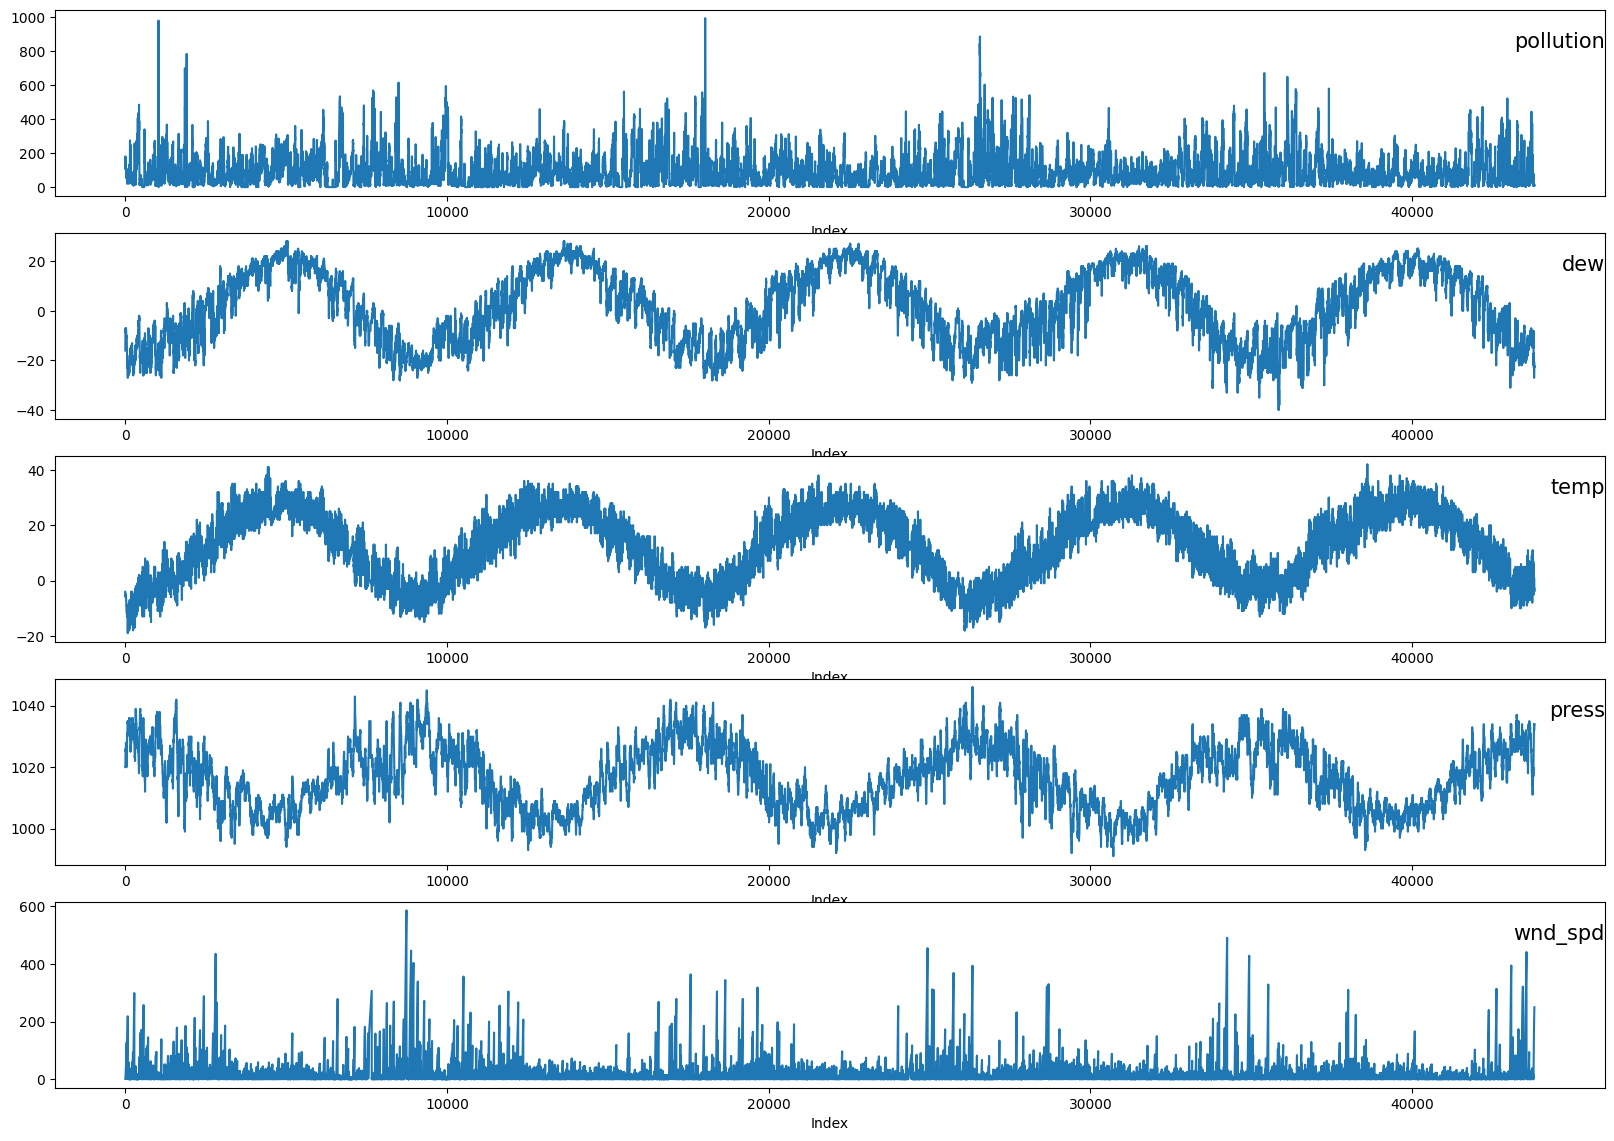

In [77]:
# Se mapean los valores de la columna 'wnd_dir' a valores numéricos
mapping = {'NE': 0, 'SE': 1, 'NW': 2, 'cv': 3}
df['wnd_dir'] = df['wnd_dir'].map(mapping)
test_df['wnd_dir'] = test_df['wnd_dir'].map(mapping)

values = df.values

# Se seleccionan las columnas a graficar
groups = [1, 2, 3, 4, 6]
i = 1

# Se grafican las columnas seleccionadas
plt.figure(figsize=(20,14))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.xlabel('Index')
    plt.title(df.columns[group], y=0.75, loc='right', fontsize = 15)
    i += 1
plt.show()

### Arquitectura de la primer red neuronal univariable

**Transformación de datos temporales:** La columna de fecha, que originalmente está en formato de tiempo, se convierte a un valor numérico usando su timestamp.

**Definición de la longitud de secuencia:** Para capturar patrones diarios, se establece una longitud de secuencia de 24, lo que permite al modelo tener en cuenta las condiciones del último día. Esta ventana temporal ayuda al modelo a observar tendencias recientes que influyen en la contaminación.

**Selección de la variable objetivo:** La red neuronal está diseñada para predecir exclusivamente los valores futuros de la variable pollution, utilizando únicamente los valores pasados de esta misma variable. Por lo tanto, pollution se define como la variable objetivo del modelo, sin considerar aún otras variables meteorológicas o de calidad del aire.

**División del conjunto de datos:** Para evaluar el rendimiento del modelo, se dividen los datos en un conjunto de entrenamiento (80%) y uno de validación (20%).

**Estructuración de los datasets temporales:** Utilizando la función timeseries_dataset_from_array, se crean los datasets de entrenamiento y validación en forma de secuencias, lo cual permite alimentar al modelo con ventanas de tiempo que respetan la longitud definida de 24.

**Construcción de la red neuronal:** La arquitectura del modelo se basa en una red LSTM. Se usa una capa LSTM de 32 unidades, que procesa la secuencia de datos y retiene información a largo plazo, seguida de una capa densa de una unidad que produce el valor predicho de contaminación.

**Compilación del modelo:** El modelo se compila utilizando MeanSquaredError como función de pérdida, y el optimizador Adam, que ajusta los pesos de la red de manera eficiente para minimizar el error.

In [ ]:
df['date'] = pd.to_datetime(df['date']).map(pd.Timestamp.timestamp)
train_data, val_data = train_test_split(df, test_size=0.2, shuffle=False)

seq_length = 24
train_target = train_data['pollution'].iloc[seq_length:].values
val_target = val_data['pollution'].iloc[seq_length:].values

train_ds = tf.keras.preprocessing.timeseries_dataset_from_array(
    data=train_target,
    targets=train_target,
    sequence_length=seq_length,
    sequence_stride=1,
    batch_size=32
)

val_ds = tf.keras.preprocessing.timeseries_dataset_from_array(
    data=val_data.iloc[:-seq_length].values,
    targets=val_target,
    sequence_length=seq_length,
    sequence_stride=1,
    batch_size=32
)

model = tf.keras.models.Sequential([
    tf.model.Input(shape=(seq_length, df.shape[1])), # Se añade la capa de entrada
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1)
])

model.compile(
    loss=tf.losses.MeanSquaredError(),
    optimizer=tf.optimizers.Adam(),
    metrics=[tf.metrics.MeanAbsoluteError()]
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min'
)

history = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=[early_stopping]
)

valid_loss, valid_mae = model.evaluate(train_ds)
print(f"Train MAE: {valid_mae:.2f}")

Epoch 1/50


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1094/1094 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - loss: 16389.7832 - mean_absolute_error: 90.8626 - val_loss: 17433.7891 - val_mean_absolute_error: 93.1491
Epoch 2/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 15677.9580 - mean_absolute_error: 87.4067 - val_loss: 16719.2422 - val_mean_absolute_error: 89.4395
Epoch 3/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 15017.2861 - mean_absolute_error: 84.1291 - val_loss: 16051.5400 - val_mean_absolute_error: 86.1460
Epoch 4/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 14401.4561 - mean_absolute_error: 81.1397 - val_loss: 15427.4707 - val_mean_absolute_error: 83.3145
Epoch 5/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 13827.6709 - mean_absolute_error: 78.5197 - val_loss: 14844.8008 - val_mean_absolute_error: 80.8615
Epoch 6/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - loss: 13293.9238 - mean_absolute_error: 76.2752 - val_loss: 14301.8740 - val_mean_absolute_error: 78.7188
Epoch 7/50
1094/1094 ━━━━━━

### Arquitectura de la primer red neuronal multivariable

**Definición de la longitud de secuencia:** Se mantiene la secuencia de 24.

**Selección de la variable objetivo:** La variable pollution sigue siendo el objetivo de predicción. Sin embargo, en esta configuración, se incluyen también las demás variables (condiciones meteorológicas y de calidad del aire previas) para proporcionar un mayor contexto a la contaminación y así lograr una predicción más informada.

**División del conjunto de datos:** De igual manera, se separan en Test (80%) y Validation (20%).

**Construcción de la red neuronal:** La arquitectura del modelo seguirá basando en una red LSTM con capas de 32 unidades.

**Compilación del modelo:** El modelo se seguirá compilando con MeanSquaredError como función de pérdida y el optimizador Adam.

En resumen, el cambio principal respecto a la configuración anterior es que ahora el modelo se entrena con mayor contexto, proporcionado por las variables adicionales, lo cual se espera que permita realizar predicciones más precisas.

In [ ]:
seq_length = 24
vars = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
train_target = train_data['pollution'].iloc[seq_length:].values
val_target = val_data['pollution'].iloc[seq_length:].values

train_multivar = tf.keras.utils.timeseries_dataset_from_array(
    data=train_data[vars].to_numpy().astype(np.float32),
    targets=train_target,
    sequence_length=seq_length,
    sequence_stride=1,
    batch_size=32,
    shuffle=True
)

val_multivar = tf.keras.utils.timeseries_dataset_from_array(
    data=val_data[vars].to_numpy().astype(np.float32),
    targets=val_target,
    sequence_length=seq_length,
    sequence_stride=1,
    batch_size=32,
    shuffle=False
)

multivar_model = tf.keras.models.Sequential([
    tf.model.Input(shape=(seq_length, len(vars))), # Se añade la capa de entrada
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1)
])

multivar_model.compile(
    loss=tf.losses.MeanSquaredError(),
    optimizer=tf.optimizers.Adam(),
    metrics=[tf.metrics.MeanAbsoluteError()]
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min'
)

history = multivar_model.fit(
    train_multivar,
    epochs=50,
    validation_data=val_multivar,
    callbacks=[early_stopping]
)

valid_loss, valid_mae = multivar_model.evaluate(val_multivar)
print(f"Validation MAE: {valid_mae:.2f}")

Epoch 1/50


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1095/1095 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - loss: 14480.8838 - mean_absolute_error: 80.9081 - val_loss: 11855.4941 - val_mean_absolute_error: 70.2958
Epoch 2/50
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 10446.5166 - mean_absolute_error: 67.3102 - val_loss: 8960.9385 - val_mean_absolute_error: 54.1040
Epoch 3/50
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 7667.0127 - mean_absolute_error: 48.8360 - val_loss: 6646.6431 - val_mean_absolute_error: 41.6193
Epoch 4/50
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - loss: 5657.2983 - mean_absolute_error: 38.7335 - val_loss: 5125.2783 - val_mean_absolute_error: 34.0860
Epoch 5/50
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 4368.2832 - mean_absolute_error: 32.5408 - val_loss: 4051.7542 - val_mean_absolute_error: 29.7310
Epoch 6/50
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 3423.4941 - mean_absolute_error: 28.1099 - val_loss: 3273.3953 - val_mean_absolute_error: 26.9364
Epoch 7/50
1095/1095 ━━━━━━━━━━━━━━━

### Arquitectura de la red neuronal multivariable actualizada

**Definición de la longitud de secuencia:** La secuencia se mantiene en 24 pasos para capturar el contexto de las últimas 24 horas.

**Selección de la variable objetivo:** La variable objetivo continúa siendo pollution y se sigue considerando la información meteorológica adicional para ofrecer al modelo un contexto más amplio que ayude a realizar predicciones informadas.

**División del conjunto de datos:** De igual manera, se separan en Test (80%) y Validation (20%).

**Construcción de la red neuronal:** La arquitectura cuenta con dos capas LSTM de 64 unidades cada una, seguidas de una capa densa de salida de 1 unidad. Este aumento en la complejidad de las capas LSTM permite capturar patrones temporales más sofisticados en los datos.

**Batch size:** El tamaño del batch se ha reducido de 32 a 16, lo que permite al modelo actualizar sus pesos con mayor frecuencia durante cada época, potencialmente mejorando la estabilidad en el entrenamiento y la convergencia.

**Compilación del modelo:** El modelo se compila usando la función de pérdida MeanSquaredError y el optimizador Nadam, que combina la eficiencia de Adam y las ventajas del gradiente acelerado de Nesterov, para mejorar la precisión y velocidad de aprendizaje.

**Regularización del entrenamiento:** Se implementa un early stopping que detiene el entrenamiento si la pérdida de validación no mejora en 5 épocas, evitando el sobreajuste.

En resumen, el cambio principal es la complejodad del modelo, con capas LSTM de 64 unidades cada una, un tamaño de batch más pequeño y el cambio del optimizador por Nadam, lo que busca mejorar la precisión de las predicciones mediante un aprendizaje más informado y detallado.

In [ ]:
train_multivar = tf.keras.utils.timeseries_dataset_from_array(
    data=train_data[vars].to_numpy().astype(np.float32),
    targets=train_target,
    sequence_length=seq_length,
    sequence_stride=1,
    batch_size=16,
    shuffle=True
)

val_multivar = tf.keras.utils.timeseries_dataset_from_array(
    data=val_data[vars].to_numpy().astype(np.float32),
    targets=val_target,
    sequence_length=seq_length,
    sequence_stride=1,
    batch_size=16,
    shuffle=False
)

multivar_model = tf.keras.models.Sequential([
    tf.model.Input(input_shape=(seq_length, len(vars))), # Se añade la capa de entrada
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1)
])

multivar_model.compile(
    loss=tf.losses.MeanSquaredError(),
    optimizer=tf.optimizers.Nadam(),
    metrics=[tf.metrics.MeanAbsoluteError()]
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min'
)

history = multivar_model.fit(
    train_multivar,
    epochs=50,
    validation_data=val_multivar,
    callbacks=[early_stopping]
)

valid_loss, valid_mae = multivar_model.evaluate(val_multivar)
print(f"Validation MAE: {valid_mae:.2f}")

Epoch 1/50


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2189/2189 ━━━━━━━━━━━━━━━━━━━━ 44s 18ms/step - loss: 11879.2705 - mean_absolute_error: 70.0856 - val_loss: 5568.5576 - val_mean_absolute_error: 37.1967
Epoch 2/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 48s 22ms/step - loss: 4306.1694 - mean_absolute_error: 32.4996 - val_loss: 2743.5569 - val_mean_absolute_error: 24.6710
Epoch 3/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 40s 18ms/step - loss: 2254.8679 - mean_absolute_error: 22.9698 - val_loss: 1645.7645 - val_mean_absolute_error: 20.1482
Epoch 4/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 40s 18ms/step - loss: 1534.2676 - mean_absolute_error: 19.7513 - val_loss: 1176.9788 - val_mean_absolute_error: 17.8258
Epoch 5/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 43s 20ms/step - loss: 1201.5089 - mean_absolute_error: 17.7082 - val_loss: 959.0275 - val_mean_absolute_error: 15.8982
Epoch 6/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 38s 18ms/step - loss: 1052.9961 - mean_absolute_error: 16.9658 - val_loss: 875.3257 - val_mean_absolute_error: 16.3141
Epoch 7/50
2189/2189 ━━━━━━━━━━━━━━━━━━━

### Arquitectura de la red neuronal multivariable actualizada

Para esta nueva arquitectura, viendo que la anterior tuvo un salto de calidad con la nueva configuración y con una mayor complejidad, se busca observar si aún se puede subir más la complejidad de la red y que esta aprenda de mejor manera. El único cambio que se hará con respecto a la anterior será aumentar el número de capas LSTM de 64 a 128.

In [ ]:
train_multivar = tf.keras.utils.timeseries_dataset_from_array(
    data=train_data[vars].to_numpy().astype(np.float32),
    targets=train_target,
    sequence_length=seq_length,
    sequence_stride=1,
    batch_size=16,
    shuffle=True
)

val_multivar = tf.keras.utils.timeseries_dataset_from_array(
    data=val_data[vars].to_numpy().astype(np.float32),
    targets=val_target,
    sequence_length=seq_length,
    sequence_stride=1,
    batch_size=16,
    shuffle=False
)

multivar_model = tf.keras.models.Sequential([
    tf.model.Input(input_shape=(seq_length, len(vars))), # Se añade la capa de entrada
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(1)
])

multivar_model.compile(
    loss=tf.losses.MeanSquaredError(),
    optimizer=tf.optimizers.Nadam(),
    metrics=[tf.metrics.MeanAbsoluteError()]
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min'
)

history = multivar_model.fit(
    train_multivar,
    epochs=50,
    validation_data=val_multivar,
    callbacks=[early_stopping]
)

valid_loss, valid_mae = multivar_model.evaluate(val_multivar)
print(f"Validation MAE: {valid_mae:.2f}")

Epoch 1/50


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2189/2189 ━━━━━━━━━━━━━━━━━━━━ 48s 20ms/step - loss: 9651.5430 - mean_absolute_error: 58.1892 - val_loss: 3029.5566 - val_mean_absolute_error: 25.0586
Epoch 2/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 46s 21ms/step - loss: 2344.3052 - mean_absolute_error: 23.0817 - val_loss: 1541.5818 - val_mean_absolute_error: 19.7979
Epoch 3/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 48s 22ms/step - loss: 1335.6018 - mean_absolute_error: 18.4923 - val_loss: 945.5657 - val_mean_absolute_error: 15.5975
Epoch 4/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 47s 21ms/step - loss: 1005.4379 - mean_absolute_error: 16.7389 - val_loss: 777.5483 - val_mean_absolute_error: 14.9047
Epoch 5/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 49s 23ms/step - loss: 908.3264 - mean_absolute_error: 16.2410 - val_loss: 696.9750 - val_mean_absolute_error: 14.4165
Epoch 6/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 50s 23ms/step - loss: 843.6249 - mean_absolute_error: 15.8593 - val_loss: 704.4782 - val_mean_absolute_error: 14.1033
Epoch 7/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 55s

### Última Arquitectura de la red neuronal multivariable actualizada

Como la anterior no tuvo mejoras, sino que tuvo peoras en el rendimiento, se va a regresar a la mejor configuración con las capas LSTM con un total de 64, pero ahora, como último intento se subirán las épocas de 50 a 100, pero de igual manera el early stopping de 5 a 10. 

In [ ]:
train_multivar = tf.keras.utils.timeseries_dataset_from_array(
    data=train_data[vars].to_numpy().astype(np.float32),
    targets=train_target,
    sequence_length=seq_length,
    sequence_stride=1,
    batch_size=16,
    shuffle=True
)

val_multivar = tf.keras.utils.timeseries_dataset_from_array(
    data=val_data[vars].to_numpy().astype(np.float32),
    targets=val_target,
    sequence_length=seq_length,
    sequence_stride=1,
    batch_size=16,
    shuffle=False
)

multivar_model = tf.keras.models.Sequential([
    tf.model.Input(input_shape=(seq_length, len(vars))), # Se añade la capa de entrada
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1)
])

multivar_model.compile(
    loss=tf.losses.MeanSquaredError(),
    optimizer=tf.optimizers.Nadam(),
    metrics=[tf.metrics.MeanAbsoluteError()]
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_absolute_error',
    patience=10,
    mode='min'
)

history = multivar_model.fit(
    train_multivar,
    epochs=100,
    validation_data=val_multivar,
    callbacks=[early_stopping]
)

valid_loss, valid_mae = multivar_model.evaluate(val_multivar)
print(f"Validation MAE: {valid_mae:.2f}")

Epoch 1/100


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2189/2189 ━━━━━━━━━━━━━━━━━━━━ 39s 16ms/step - loss: 11539.1211 - mean_absolute_error: 67.8873 - val_loss: 5461.0215 - val_mean_absolute_error: 36.5136
Epoch 2/100
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 30s 14ms/step - loss: 4067.6167 - mean_absolute_error: 31.4227 - val_loss: 2709.6204 - val_mean_absolute_error: 24.0155
Epoch 3/100
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 29s 13ms/step - loss: 2093.6587 - mean_absolute_error: 22.2338 - val_loss: 1616.8037 - val_mean_absolute_error: 19.6775
Epoch 4/100
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 29s 13ms/step - loss: 1389.6517 - mean_absolute_error: 18.7573 - val_loss: 1113.2391 - val_mean_absolute_error: 16.9274
Epoch 5/100
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step - loss: 1108.3641 - mean_absolute_error: 17.1203 - val_loss: 905.1533 - val_mean_absolute_error: 15.5309
Epoch 6/100
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step - loss: 974.5712 - mean_absolute_error: 16.4686 - val_loss: 793.5562 - val_mean_absolute_error: 15.0664
Epoch 7/100
2189/2189 ━━━━━━━━━━━━━━

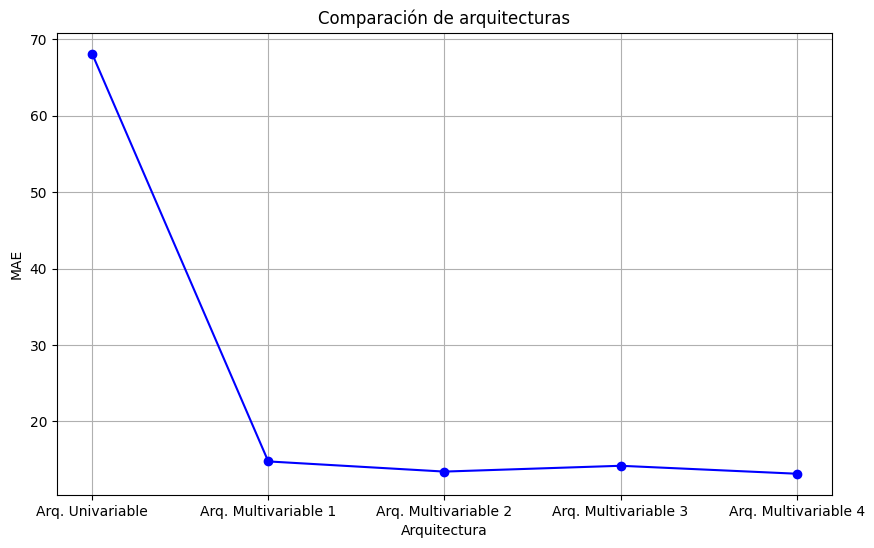

In [110]:
arq = ['Arq. Univariable', 'Arq. Multivariable 1', 'Arq. Multivariable 2', 'Arq. Multivariable 3', 'Arq. Multivariable 4']
mae = [68.13, 14.76, 13.43, 14.19, 13.15]

plt.figure(figsize=(10,6))
plt.plot(arq, mae, marker='o', linestyle='-', color='b')
plt.xlabel('Arquitectura')
plt.ylabel('MAE')
plt.title('Comparación de arquitecturas')
plt.grid()
plt.show()

En conclusión, la comparación entre las cinco arquitecturas muestra que los modelos multivariables superan claramente al modelo univariable en precisión de predicción. Al incluir variables adicionales como condiciones meteorológicas junto con la contaminación, los modelos multivariables logran reducir significativamente el MAE, lo que indica que esta información adicional permite al modelo captar mejor las dinámicas que tienen estas variables sobre la contaminación. 

Aunque entre las cuatro arquitecturas multivariables hay ligeras diferencias en desempeño, todas demuestran que este tipo de arquitecturas ofrecen una mejora sustancial en la predicción en comparación con un enfoque que solo considera una única variable. Esto refuerza la importancia de incorporar múltiples factores para una predicción más precisa en problemas complejos como la contaminación ambiental.

En cuanto a las arquitecturas multivariables, se pudo observar que no siempre más complejidad trae mejores resultados, es importante encontrar cierto balance entre los hiperparámetros, y aunque entre estas mismas arquitecturas hubo mejoras, no son significativas entre ellas.

Un área de mejora es probar con más datos que den un mayor contexto a los que se tienen, y con respecto al modelo, la cuestión es seguir experimentando con los hiperparámetros, como lo puede ser las épocas, o incluso la complejidad del modelo.

In [112]:
multivar_model.save('A01026488_multivar_model.keras')

## Test
- Se usarán los datos de test para predecir la contaminación atmosférica en la ciudad de Beijing.
- Estos datos no se usaron para entrenar el modelo, por lo que se espera que el modelo pueda generalizar.
- Si se desea probar con otros datos, se puede cambiar el path del archivo de test en la función cargar_datos, pero se debe tener en cuenta que los datos deben tener las mismas columnas que el archivo de test original.

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


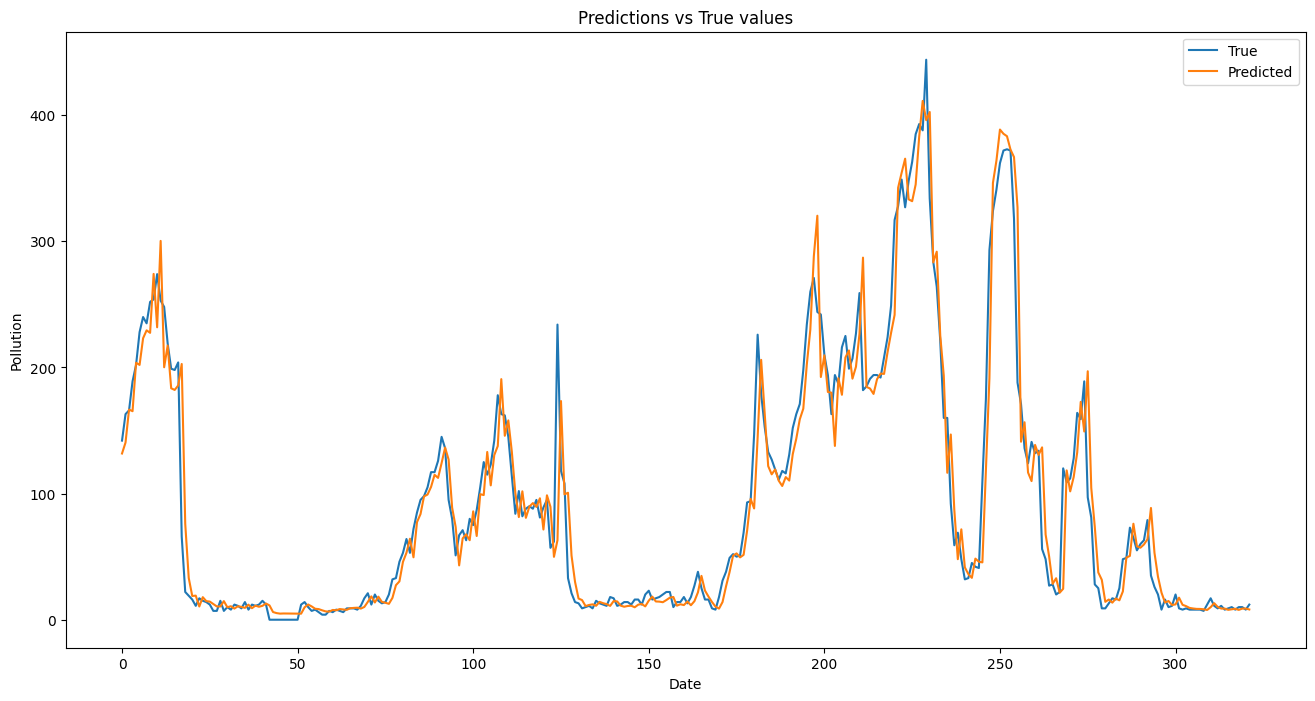

In [139]:
from tensorflow.keras.models import load_model

def cargar_datos():    
    path = kagglehub.dataset_download("rupakroy/lstm-datasets-multivariate-univariate")
    test_csv_path = f"{path}/pollution_test_data1.csv"
    data = pd.read_csv(test_csv_path)
    mapping = {'NE': 0, 'SE': 1, 'NW': 2, 'cv': 3}
    data['wnd_dir'] = data['wnd_dir'].map(mapping)
    return data

def forecast(data, multivar_model, vars, seq_length):
    test_target = data['pollution'].iloc[seq_length:].values

    test_multivar = tf.keras.utils.timeseries_dataset_from_array(
        data=data[vars].to_numpy().astype(np.float32),
        targets=test_target,
        sequence_length=seq_length,
        sequence_stride=1,
        batch_size=16,
        shuffle=False
    )

    predictions = multivar_model.predict(test_multivar)  

    plt.figure(figsize=(16,8))
    plt.plot(test_target, label='True')
    plt.plot(predictions, label='Predicted')
    plt.title(f'Predictions vs True values')
    plt.xlabel('Date')
    plt.ylabel('Pollution')
    plt.legend()
    plt.show()

def main():
    data = cargar_datos()
    multivar_model = load_model('A01026488_multivar_model.keras')
    vars = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
    seq_length = 24
    forecast(data, multivar_model, vars, seq_length)

if __name__ == '__main__':
    main()